# Lab. 8: Multi-Objective Optimization

## Introduction

#### <u>The goal of this lab is to study different Multi-Objective Optimization approaches.</u>

For this problem, we will use two problems as benchmarks:
1. Kursawe's function:
$\underset{x}{min}\begin{cases}f_1(x) &= \sum_{i=1}^{n-1} \left[-10e^{-0.2\sqrt{x_i^2 + x_{i+1}^2}}\right] \\ f_2(x) &= \sum_{i=1}^n \left[|x_i|^{0.8} + 5\sin(x_i)^3\right] \\\end{cases}$ s.t. $x_i \in [-5, 5]; i \in [1,n]$
2. Multiple-disk clutch brake optimization: This real world optimization problem consists in the optimization of 5 paramters concernining multiple-disk clutch brakes. The parameters are shown visually in the image below.
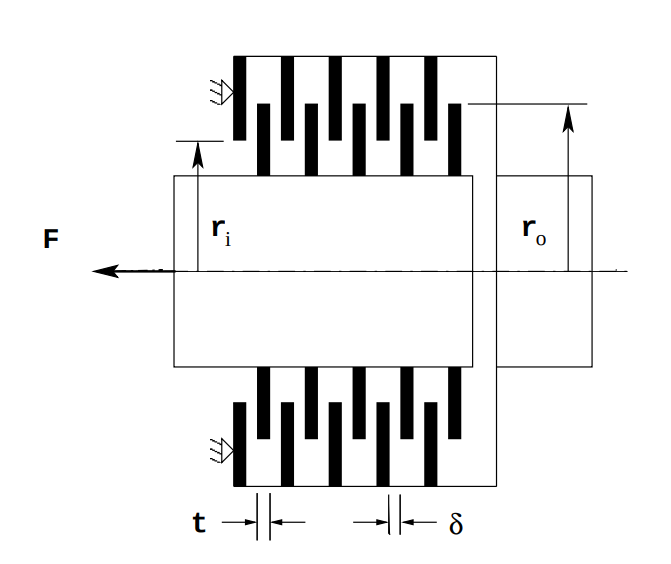

(Image taken from Deb and Srinivasan, "Innovization: Innovative Design Principles Through Optimization")

Two conflicting objectives are considered in the problem of this exercise:
1. minimization of break system mass(in kg)
2. minimization of stopping time(in s).

This problem is characterzied by five decision variables that are:
1. $r_i$ the inner radius in mm. $r_i = (60, 61, 62, . . . , 78, 79, 80)mm$
2. $r_o$ the outer radius in . $r_o = (90, 91, 92, . . . , 108, 109, 110)mm$
3. $t$ the tickness of discs in mm. $t = (1, 1.5, 2, 2.5, 3)mm$
4. $F$ the actuating force in N(Newton). $F = (600, 610, 620, . . . , 980, 990, 1000)N$
5. $Z$ the number of discs. $Z = (2, 3, 4, 5, 6, 7, 8, 10)$

**For each of the exercises, perform multiple runs (with different random seeds) to reduce the effect of randomness on the results.**

### Helper functions

In [2]:
%%capture
!pip install inspyred

In [3]:
import copy
import functools
from pylab import *
from inspyred import benchmarks
import inspyred
from inspyred.ec.emo import Pareto
from numpy.random import RandomState
from inspyred.ec.variators import mutator
from inspyred.ec import EvolutionaryComputation
from inspyred.ec import terminators, variators, replacers, selectors

In [4]:
#@markdown Implementation of benchmarks and utilites (double click to open)

def choice_without_replacement(rng, n, size) :
    result = set()
    while len(result) < size :
        result.add(rng.randint(0, n))
    return result

class NumpyRandomWrapper(RandomState):
    def __init__(self, seed=None):
        super(NumpyRandomWrapper, self).__init__(seed)

    def sample(self, population, k):
        if isinstance(population, int) :
            population = range(population)

        return asarray([population[i] for i in
                        choice_without_replacement(self, len(population), k)])
        #return #self.choice(population, k, replace=False)

    def random(self):
        return self.random_sample()

    def gauss(self, mu, sigma):
        return self.normal(mu, sigma)

def initial_pop_observer(population, num_generations, num_evaluations,
                         args):
    if num_generations == 0 :
        args["initial_pop_storage"]["individuals"] = asarray([guy.candidate
                                                 for guy in population])
        args["initial_pop_storage"]["fitnesses"] = asarray([guy.fitness
                                          for guy in population])

def generator(random, args):
    return asarray([random.uniform(args["pop_init_range"][0],
                                   args["pop_init_range"][1])
                    for _ in range(args["num_vars"])])

def generator_wrapper(func):
        @functools.wraps(func)
        def _generator(random, args):
            return asarray(func(random, args))
        return _generator

class CombinedObjectives(Pareto):
    def __init__(self, pareto, args):
        """ edit this function to change the way that multiple objectives
        are combined into a single objective

        """

        Pareto.__init__(self, pareto.values)
        if "fitness_weights" in args :
            weights = asarray(args["fitness_weights"])
        else :
            weights = asarray([1 for _ in pareto.values])

        # Custom combination method: Sum of squares of weighted objectives
        self.fitness = sum((asarray(pareto.values) * weights) ** 2) ** 0.5
        #self.fitness = sum(asarray(pareto.values) * weights)

    def __lt__(self, other):
        return self.fitness < other.fitness

def single_objective_evaluator(candidates, args):
    problem = args["problem"]
    return [CombinedObjectives(fit,args) for fit in
            problem.evaluator(candidates, args)]

# parameters, see Deb 2006
Delta_R = 20 # mm
L_max = 30 # mm
delta = 0.5 # mm
p_max = 1 # MPa
V_sr_max = 10 # m/s
n = 250 # rpm
mu = 0.5
s = 1.5
M_s = 40 # Nm
omega = pi * n/30. # rad/s
rho = 0.0000078 # kg/mm^3
T_max = 15 # s
M_f = 3 # Nm
I_z = 55 # kg*m^2

#possible values
values = [arange(60,81,1), arange(90,111,1), arange(1.5,3.5, 0.5),
          arange(600,1010,10), arange(2,10,1)]


class DiskClutchBounder(object):
    def __call__(self, candidate, args):
        closest = lambda target, index: min(values[index],
                                            key=lambda x: abs(x-target))
        for i, c in enumerate(candidate):
            candidate[i] = closest(c,i)
        return candidate

class ConstrainedPareto(Pareto):
    def __init__(self, values=None, violations=None, ec_maximize=True):
        Pareto.__init__(self, values)
        self.violations = violations
        self.ec_maximize=ec_maximize

    def __lt__(self, other):
        if self.violations is None :
            return Pareto.__lt__(self, other)
        elif len(self.values) != len(other.values):
            raise NotImplementedError
        else:
            if self.violations > other.violations :
                # if self has more violations than other
                # return true if EC is maximizing otherwise false
                return (self.ec_maximize)
            elif other.violations > self.violations :
                # if other has more violations than self
                # return true if EC is minimizing otherwise false
                return (not self.ec_maximize)
            elif self.violations > 0 :
                # if both equally infeasible (> 0) than cannot compare
                return False
            else :
                # only consider regular dominance if both are feasible
                not_worse = True
                strictly_better = False
                for x, y, m in zip(self.values, other.values, self.maximize):
                    if m:
                        if x > y:
                            not_worse = False
                        elif y > x:
                            strictly_better = True
                    else:
                        if x < y:
                            not_worse = False
                        elif y < x:
                            strictly_better = True
            return not_worse and strictly_better

class DiskClutchBrake(benchmarks.Benchmark):

    def __init__(self, constrained=False) :
        benchmarks.Benchmark.__init__(self, 5, 2)
        self.bounder = DiskClutchBounder()
        self.maximize = False
        self.constrained=constrained

    def generator(self, random, args):
        return [random.sample(values[i],1)[0] for i in range(self.dimensions)]

    def evaluator(self, candidates, args):
        fitness = []
        for c in candidates:
            f1 = pi * (c[1] ** 2 - c[0] ** 2) * c[2] * (c[4] + 1) * rho

            M_h = ( (2./3.) * mu * c[3] * c[4]  *
                (c[1] ** 3 - c[0] ** 3) /
                (c[1] ** 2 - c[0] ** 2) ) / 1000. # N*m
            T = (I_z * omega) / (M_h + M_f)

            f2 = T

            fitness.append(ConstrainedPareto([f1, f2],
                                             self.constraint_function(c),
                                             self.maximize))

        return fitness

    def constraint_function(self,candidate):
        if not self.constrained :
            return 0
        """Return the magnitude of constraint violations."""
        A = pi * (candidate[1] ** 2 - candidate[0] ** 2) # mm^2
        p_rz = candidate[3]/A # N/mm^2
        R_sr = ( (2./3.) * (candidate[1] ** 3 - candidate[0] ** 3) /
                 (candidate[1] ** 2 - candidate[0] ** 2) )  # mm
        V_sr = pi * R_sr * n / 30000. # m/s

        M_h = ( (2./3.) * mu * candidate[3] * candidate[4]  *
                (candidate[1] ** 3 - candidate[0] ** 3) /
                (candidate[1] ** 2 - candidate[0] ** 2) ) / 1000. # N*m

        T = (I_z * omega) / (M_h + M_f)

        violations = 0
        #g_1
        if (candidate[1] - candidate[0] - Delta_R) < 0 :
            violations -= (candidate[1] - candidate[0] - Delta_R)
        #g_2
        if (L_max - (candidate[4] + 1)*(candidate[2] + delta)) < 0 :
            violations -= (L_max - (candidate[4] + 1)*(candidate[2] + delta))
        #g_3
        if (p_max - p_rz) < 0 :
            violations -= (p_max - p_rz)
        #g_4
        if (p_max*V_sr_max - p_rz * V_sr) < 0 :
            violations -= (p_max*V_sr_max - p_rz * V_sr)
        #g_5
        if (V_sr_max - V_sr) < 0 :
            violations -= (V_sr_max - V_sr)
        #g_6
        if ( M_h - s * M_s) < 0 :
            violations -= ( M_h - s * M_s)
        #g_7
        if ( T < 0 ) :
            violations -= T
        #g_8
        if  (T_max - T) < 0 :
            violations -= (T_max - T)

        return violations

@mutator
def disk_clutch_brake_mutation(random, candidate, args):
    mut_rate = args.setdefault('mutation_rate', 0.1)
    bounder = args['_ec'].bounder
    mutant = copy(candidate)
    for i, m in enumerate(mutant):
        if random.random() < mut_rate:
            mutant[i] += random.gauss(0, (values[i][-1] - values[i][0]) / 10.0 )
    mutant = bounder(mutant, args)
    return mutant

import math

class NSGA2(inspyred.ec.emo.NSGA2):
    # helper function used to store the various populations at each generation
    def _best_archiver(self, random, population, archive, args):
        self.population_archive.append(population)
        new_archive = archive
        for ind in population:
            if len(new_archive) == 0:
                new_archive.append(ind)
            else:
                should_remove = []
                should_add = True
                for a in new_archive:
                    if (np.array(ind.candidate) == np.array(a.candidate)).all():
                        should_add = False
                        break
                    elif ind < a:
                        should_add = False
                    elif ind > a:
                        should_remove.append(a)
                for r in should_remove:
                    new_archive.remove(r)
                if should_add:
                    new_archive.append(ind)
        return new_archive

def run_nsga2(random, problem, display=False, num_vars=0, use_bounder=True,
        variator=None, **kwargs) :
    """ run NSGA2 on the given problem """

    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = NSGA2(random)
    algorithm.population_archive = []
    algorithm.archiver = algorithm._best_archiver
    algorithm.terminator = terminators.generation_termination
    if variator is None :
        algorithm.variator = [variators.blend_crossover,
                              variators.gaussian_mutation]
    else :
        algorithm.variator = variator

    kwargs["num_selected"]=kwargs["pop_size"]
    if use_bounder :
        kwargs["bounder"]=problem.bounder

    if "pop_init_range" in kwargs :
        kwargs["generator"]=generator
    else :
        kwargs["generator"]=problem.generator
    final_pop = algorithm.evolve(evaluator=problem.evaluator,
                          maximize=problem.maximize,
                          initial_pop_storage=initial_pop_storage,
                          num_vars=num_vars,
                          **kwargs)

    all_populations = algorithm.population_archive
    for i in range(len(all_populations)):
        all_populations[i] = np.array([elem.fitness for elem in all_populations[i]])

    best_guy = final_pop[0].candidate[0:num_vars]
    best_fitness = final_pop[0].fitness
    #final_pop_fitnesses = asarray([guy.fitness for guy in algorithm.archive])
    #final_pop_candidates = asarray([guy.candidate[0:num_vars] for guy in algorithm.archive])
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate[0:num_vars] for guy in final_pop])

    return final_pop_candidates, final_pop_fitnesses, all_populations, best_guy, best_fitness

def run_ga(random,problem, display=False, num_vars=0,
           maximize=False, use_bounder=True, **kwargs) :
    """ run a GA on the given problem """

    #create dictionaries to store data about initial population, and lines
    initial_pop_storage = {}

    algorithm = EvolutionaryComputation(random)
    algorithm.terminator = terminators.generation_termination
    algorithm.replacer = replacers.generational_replacement
    algorithm.variator = [variators.uniform_crossover,
                          variators.gaussian_mutation]
    algorithm.selector = selectors.tournament_selection
    algorithm.observer = [initial_pop_observer]

    kwargs["num_selected"]=kwargs["pop_size"]
    if use_bounder :
        kwargs["bounder"]=problem.bounder
    if "pop_init_range" in kwargs :
        kwargs["generator"]=generator
    else :
        kwargs["generator"]=problem.generator

    kwargs["problem"] = problem
    final_pop = algorithm.evolve(evaluator=single_objective_evaluator,
                                 maximize=problem.maximize,
                                 initial_pop_storage=initial_pop_storage,
                                 num_vars=num_vars,
                                 **kwargs)

    best_guy = final_pop[0].candidate
    best_fitness = final_pop[0].fitness.fitness
    final_pop_fitnesses = asarray([guy.fitness for guy in final_pop])
    final_pop_candidates = asarray([guy.candidate for guy in final_pop])

    return best_guy, best_fitness, final_pop_fitnesses, final_pop_candidates

def plot_pareto(final_pop_fitnesses, function_labels=None):
    plt.scatter(final_pop_fitnesses.T[0], final_pop_fitnesses.T[1], color="red", label="Pareto front")

    if not function_labels:
        plt.xlabel("f1")
        plt.ylabel("f2")
    else:
        plt.xlabel(function_labels[0])
        plt.ylabel(function_labels[1])

    plt.legend(loc="upper right")
    plt.legend()
    plt.show()

def plot_pareto_rank(all_populations, function_labels=None):
    fig, ax = plt.subplots(1,1)
    fig.set_figwidth(10)
    fig.set_figheight(7)

    pareto_front = all_populations[-1]
    ax.scatter(pareto_front.T[0], pareto_front.T[1], color="red", label="Pareto front")

    for i in range(min(len(all_populations), 5)):
        ax.scatter(all_populations[i].T[0], all_populations[i].T[1], label=("Front " + str(i+1)))

    if not function_labels:
        ax.set_xlabel("f1")
        ax.set_ylabel("f2")
    else:
        ax.set_xlabel(function_labels[0])
        ax.set_ylabel(function_labels[1])
    plt.legend(loc="upper right")
    plt.legend()
    plt.show()

In [5]:
def plot_convergence_curve(final_pop_fitnesses):
    plt.figure()
    plt.plot(final_pop_fitnesses)
    plt.title("Convergence Curve")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.show()

### Exercises

#### Exercise 1/2: Kursawe's function

1. Weighted sum of the objectives: what's the influence of the weights on the output of the search process?
2. Using NSGA-II, plot the Pareto front of the solutions obtained during the optimization process.
3. Compare the weighted-sum method with NSGA-II


------------------------------------

GA algorithm



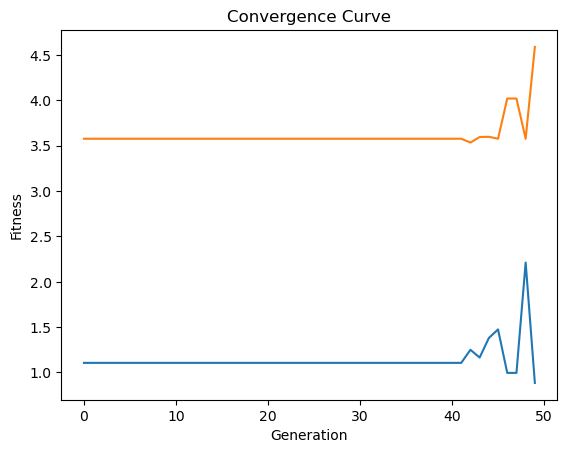

Best Solution: [80, 97, 1.5, 1000, 9]
Best Fitness: 3.744667850214919

------------------------------------

NSGA-II algorithm



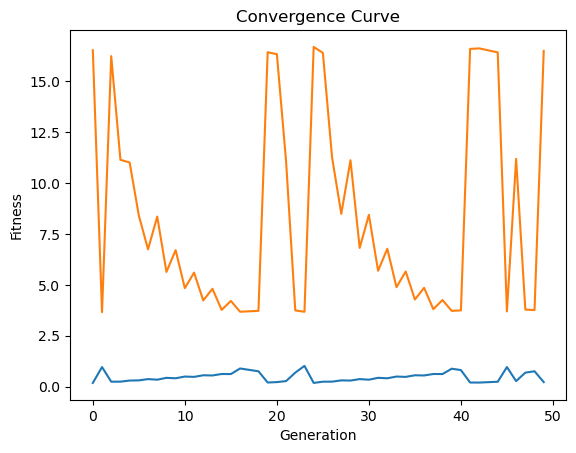

Best Solution: [80, 90, 1.5]
Best Fitness: [0.18745883363970295, 16.50366960573117]


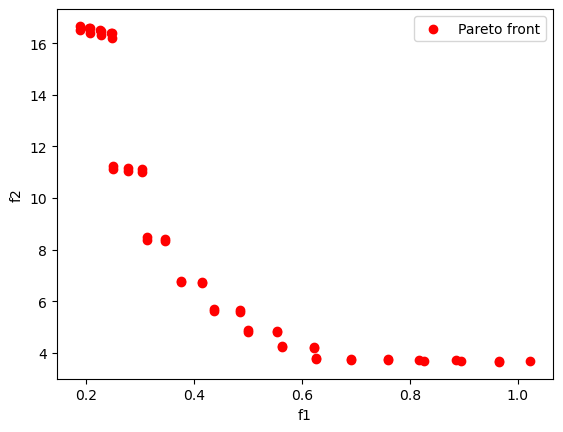

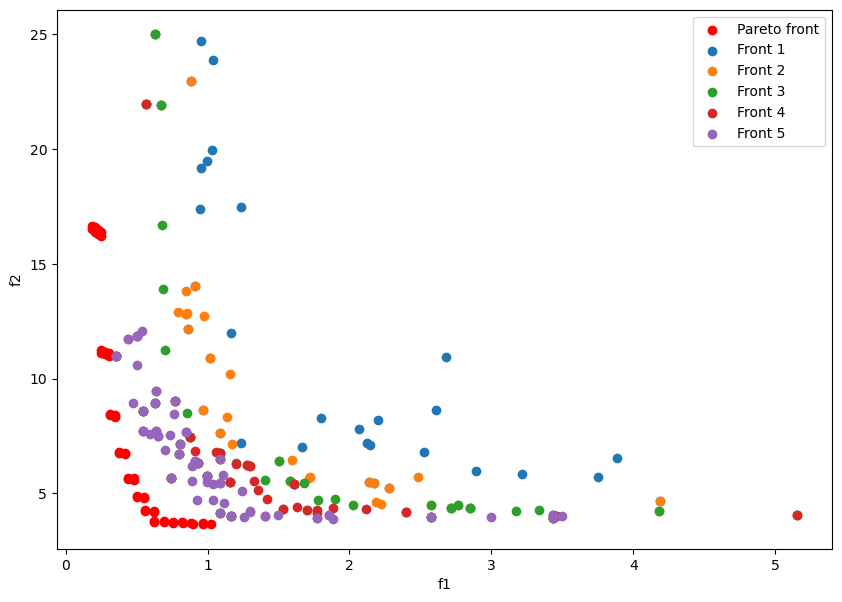

In [9]:
# Instantiate the problem
problem = benchmarks.Kursawe(3)

# Parameters for the GA
args = {}
args["pop_size"] = 50
args["max_generations"] = 100

weight_configurations = [
    [1, 1],   # Equal weights for both objectives
    [2, 1],   # Emphasize the first objective
    [1, 2],   # Emphasize the second objective
    [3, 0.5], # Emphasize the first, de-emphasize the second
    [0.5, 3], # Emphasize the second, de-emphasize the first
    [0, 1],   # Only consider the first objective
    [1, 0]    # Only consider the second objective
]
# args["fitness_weights"] = [1, 1] 

rng = NumpyRandomWrapper(10)  # Initialize a random number generator with a seed


print()
print("------------------------------------")
print()
print("GA algorithm")
print()

# Run GA algorithm
best_guy, best_fitness, final_pop_fitnesses, final_pop_candidates = run_ga(rng, problem, num_vars=3, maximize=False, **args)
plot_convergence_curve(final_pop_fitnesses)
print("Best Solution:", best_guy)
print("Best Fitness:", best_fitness)


print()
print("------------------------------------")
print()
print("NSGA-II algorithm")
print()


# Run NSGA-II algorithm
final_pop_candidates, final_pop_fitnesses, all_populations, best_guy, best_fitness = run_nsga2(rng, problem, num_vars=3, **args)

plot_convergence_curve(final_pop_fitnesses)
print("Best Solution:", best_guy)
print("Best Fitness:", best_fitness)

# Plot NSGA-II Pareto front
plot_pareto(final_pop_fitnesses)

plot_pareto_rank(all_populations)


#### Exercise 2/2: Multi-disk clutch brake optimization
1. Weighted sum of the objectives: what's the influence of the weights on the output of the search process?
2. Using NSGA-II, plot the Pareto front of the solutions obtained during the optimization process.
3. Compare the weighted-sum method with NSGA-II


------------------------------------

GA algorithm



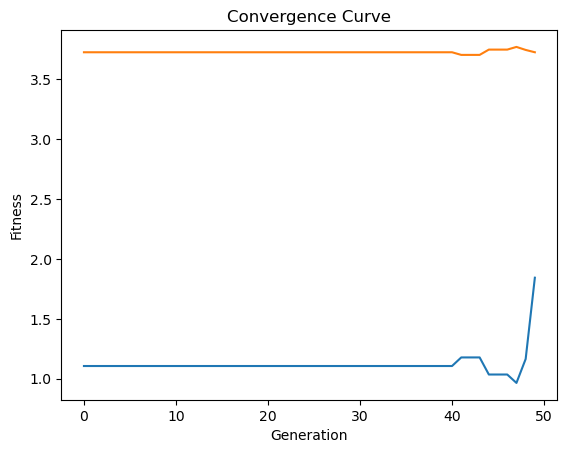

Best Solution: [80, 97, 1.5, 960, 9]
Best Fitness: 3.8862247407068966

------------------------------------

NSGA-II algorithm



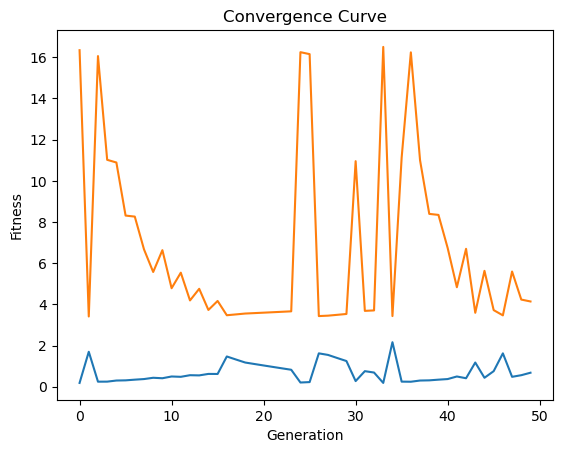

Best Solution: [80, 90, 1.5]
Best Fitness: [0.18745883363970295, 16.344252899546277]


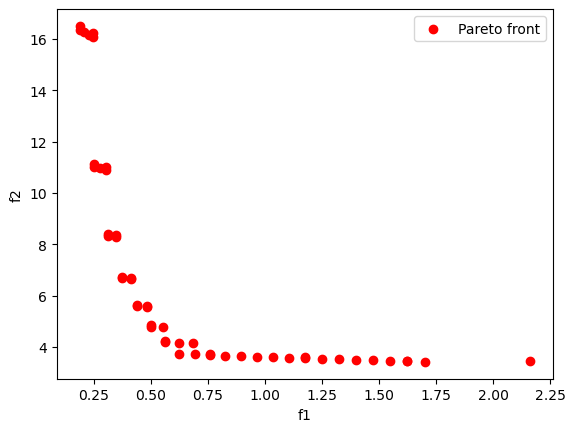

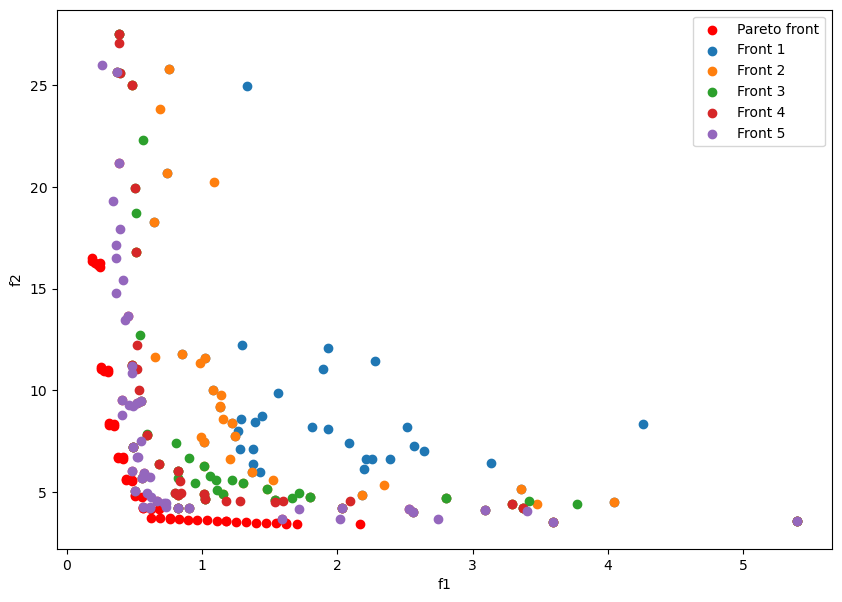

In [8]:
# parameters for NSGA-2
args = {}
args["pop_size"] = 50
args["max_generations"] = 50
#args["variator"] = [variators.blend_crossover,disk_clutch_brake_mutation]

problem2 = DiskClutchBrake(False)  # Initialize the problem

rng = NumpyRandomWrapper(40)  # Initialize a random number generator with a seed


print()
print("------------------------------------")
print()
print("GA algorithm")
print()

# Run GA algorithm
best_guy, best_fitness, final_pop_fitnesses, final_pop_candidates = run_ga(rng, problem2, num_vars=3, maximize=False, **args)
plot_convergence_curve(final_pop_fitnesses)
print("Best Solution:", best_guy)
print("Best Fitness:", best_fitness)

rng = NumpyRandomWrapper(50)  # Initialize a random number generator with a seed

print()
print("------------------------------------")
print()
print("NSGA-II algorithm")
print()


# Run NSGA-II algorithm
final_pop_candidates, final_pop_fitnesses, all_populations, best_guy, best_fitness = run_nsga2(rng, problem2, num_vars=3, **args)

plot_convergence_curve(final_pop_fitnesses)
print("Best Solution:", best_guy)
print("Best Fitness:", best_fitness)

# Plot NSGA-II Pareto front
plot_pareto(final_pop_fitnesses)

plot_pareto_rank(all_populations)
